In [5]:
pip install torch torchvision

In [6]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar -xvf maps.tar.gz

--2026-02-26 14:12:36--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M   668KB/s    in 7m 2s   

2026-02-26 14:19:38 (579 KB/s) - ‘maps.tar.gz’ saved [250242400/250242400]

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531

In [7]:
!ls

maps  maps.tar.gz  sample_data


In [8]:
!ls maps

train  val


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

In [12]:
class MapsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [f for f in os.listdir(root_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")

        w, h = img.size
        input_img = img.crop((0, 0, w//2, h))
        target_img = img.crop((w//2, 0, w, h))

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

In [13]:
dataset = MapsDataset("maps/train", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 1, 4, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [16]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [17]:
criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [18]:
num_epochs = 20

for epoch in range(num_epochs):
    for i, (real_input, real_target) in enumerate(dataloader):

        real_input = real_input.to(device)
        real_target = real_target.to(device)

        # Generate fake INSIDE the loop
        fake = generator(real_input)

        # --------------------
        # Train Discriminator
        # --------------------
        pred_real = discriminator(torch.cat((real_input, real_target), 1))
        real_label = torch.ones_like(pred_real).to(device)
        loss_D_real = criterion_GAN(pred_real, real_label)

        pred_fake = discriminator(torch.cat((real_input, fake.detach()), 1))
        fake_label = torch.zeros_like(pred_fake).to(device)
        loss_D_fake = criterion_GAN(pred_fake, fake_label)

        loss_D = (loss_D_real + loss_D_fake) * 0.5

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # --------------------
        # Train Generator
        # --------------------
        pred_fake = discriminator(torch.cat((real_input, fake), 1))
        real_label = torch.ones_like(pred_fake).to(device)

        loss_GAN = criterion_GAN(pred_fake, real_label)
        loss_L1 = criterion_L1(fake, real_target)

        loss_G = loss_GAN + 100 * loss_L1

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")

Epoch [1/20]  Loss_D: 0.2128  Loss_G: 21.9100
Epoch [2/20]  Loss_D: 0.3429  Loss_G: 13.3173
Epoch [3/20]  Loss_D: 0.2539  Loss_G: 10.9850
Epoch [4/20]  Loss_D: 0.1675  Loss_G: 13.9604
Epoch [5/20]  Loss_D: 0.2846  Loss_G: 14.4461
Epoch [6/20]  Loss_D: 0.3083  Loss_G: 13.0063
Epoch [7/20]  Loss_D: 0.1933  Loss_G: 13.1305
Epoch [8/20]  Loss_D: 0.1981  Loss_G: 12.1740
Epoch [9/20]  Loss_D: 0.2479  Loss_G: 11.4351
Epoch [10/20]  Loss_D: 0.2190  Loss_G: 12.7082
Epoch [11/20]  Loss_D: 0.2424  Loss_G: 10.9035
Epoch [12/20]  Loss_D: 0.1721  Loss_G: 11.6707
Epoch [13/20]  Loss_D: 0.3959  Loss_G: 11.5097
Epoch [14/20]  Loss_D: 0.0964  Loss_G: 12.4162
Epoch [15/20]  Loss_D: 0.1376  Loss_G: 11.8860
Epoch [16/20]  Loss_D: 0.1589  Loss_G: 11.6023
Epoch [17/20]  Loss_D: 0.2284  Loss_G: 12.3885
Epoch [18/20]  Loss_D: 0.1737  Loss_G: 12.3760
Epoch [19/20]  Loss_D: 0.1149  Loss_G: 13.0645
Epoch [20/20]  Loss_D: 0.1974  Loss_G: 12.9786


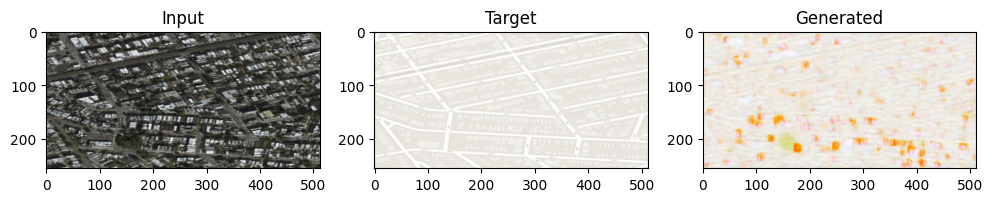

Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): Tanh()
  )
)

In [19]:
generator.eval()

sample_input, sample_target = next(iter(dataloader))
sample_input = sample_input.to(device)

with torch.no_grad():
    fake = generator(sample_input)

input_img = sample_input[0].cpu().permute(1,2,0) * 0.5 + 0.5
target_img = sample_target[0].cpu().permute(1,2,0) * 0.5 + 0.5
fake_img = fake[0].cpu().permute(1,2,0) * 0.5 + 0.5

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(input_img)
plt.title("Input")

plt.subplot(1,3,2)
plt.imshow(target_img)
plt.title("Target")

plt.subplot(1,3,3)
plt.imshow(fake_img)
plt.title("Generated")

plt.show()

generator.train()

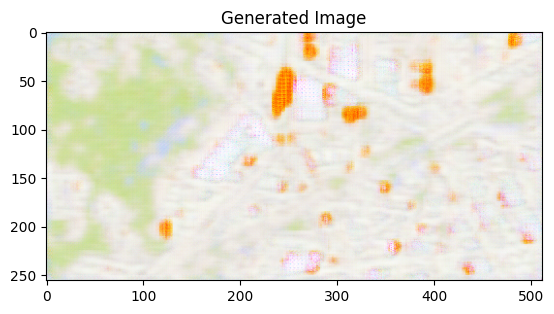

In [20]:
generator.train()
sample_input, _ = next(iter(dataloader))
sample_input = sample_input.to(device)

with torch.no_grad():
    fake = generator(sample_input)

plt.imshow(fake[0].cpu().permute(1,2,0) * 0.5 + 0.5)
plt.title("Generated Image")
plt.show()